In [3]:
# Cell 0: 공통
import os, json, math, random, re
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms, datasets

import clip

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

ROOT = "."
DATA_ROOT = os.path.join(ROOT, "data")
RUNS_ROOT = os.path.join(ROOT, "runs_ft")
os.makedirs(RUNS_ROOT, exist_ok=True)

# 하이퍼파라미터
BATCH_SIZE = 32
NUM_WORKERS = 0
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# ResNet 확장 학습
EPOCHS_OBJ = 8
LR_OBJ = 3e-4
WD_OBJ = 1e-4

# CLIP 미세조정 (대비학습)
EPOCHS_CLIP = 6
LR_CLIP = 5e-6     # CLIP은 작은 lr 권장 (필요시 1e-5 ~ 5e-6 사이 탐색)
WD_CLIP = 0.0

# 추론 규칙(이전 요구대로 유지)
OBJECT_THRESHOLD = 0.20    # 객체: 0.5 이상 모두
TOPK_SCENE = 2
TOPK_MOOD  = 2

def to_hashtag(s: str) -> str:
    return "#" + s.strip().replace(" ", "_")


In [ ]:
# pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\kdt41\appdata\local\temp\pip-req-build-27k64e3k
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/44.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/44.8 kB ? eta -:--:--
   --------- ------------------------------ 10.2/44.8 kB ? eta -:--:--
   ------------------------------------ --- 41.0/44.8 kB 326.8 kB/s eta 0:00:01
   ------------------------------------ --- 41.0/44.8 kB 326.8 kB/s eta 0:00:01
   ---------------------------------------- 44.8/44.8 kB 221.7 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369631 sha256=9acba9c77dffe393dce4bf88fe6524d712762c68661193236177c951810a0060
  Stored in directory: C:\Users\KDT41\AppData\Local\Temp\pip-ephem-wheel-cache-wu189qvo\wheels\da\2

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\KDT41\AppData\Local\Temp\pip-req-build-27k64e3k'
DEPRECATION: mecab-python 0.996-ko-0.9.2-msvc has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mecab-python or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Cell 1: Transform / Split / Helper
def tfms_train(size=224):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

def tfms_eval(size=224):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

def build_splits(ds, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO):
    n = len(ds)
    n_val = int(n * val_ratio)
    n_test = int(n * test_ratio)
    n_train = n - n_val - n_test
    return random_split(ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(SEED))

def clean_caption_from_filename(name: str) -> str:
    # 파일명 -> 캡션: 확장자 제거, 언더스코어/대시를 공백으로
    base = os.path.splitext(os.path.basename(name))[0]
    base = re.sub(r'[_\-]+', ' ', base)
    return base.strip()


In [5]:
# Cell 2: ResNet 확장 분류기 (기존 1000 + 새 클래스)
def load_imagenet_resnet50():
    w = models.ResNet50_Weights.IMAGENET1K_V1
    base = models.resnet50(weights=w)
    base.eval()
    imagenet_classes = w.meta["categories"]  # 길이 1000
    return base, imagenet_classes

def build_extended_fc(old_fc: nn.Linear, num_new: int) -> nn.Linear:
    in_dim = old_fc.in_features
    out_old = old_fc.out_features
    out_new = out_old + num_new
    new_fc = nn.Linear(in_dim, out_new)
    # 기존 가중치/바이어스 복사
    with torch.no_grad():
        new_fc.weight[:out_old] = old_fc.weight
        new_fc.bias[:out_old]   = old_fc.bias
        # 나머지 새 행은 Kaiming/Zero 초기화
        nn.init.kaiming_normal_(new_fc.weight[out_old:])
        nn.init.constant_(new_fc.bias[out_old:], 0.0)
    return new_fc

def map_ext_classes(object_root: str, imagenet_classes: List[str]):
    """
    object_ext 폴더의 클래스명을 확인:
    - 폴더명이 ImageNet 클래스명과 '완전 일치'하면 old 클래스로 간주(강화학습 대상)
    - 그렇지 않으면 new 클래스로 간주(확장)
    """
    # ImageFolder로 클래스명 확보
    ds_tmp = datasets.ImageFolder(object_root, transform=tfms_train())
    custom_classes = ds_tmp.classes  # 폴더명 사전순
    # 매핑
    name_to_idx_imagenet = {name: i for i, name in enumerate(imagenet_classes)}
    old_indices, new_names = [], []
    for cname in custom_classes:
        if cname in name_to_idx_imagenet:
            old_indices.append(name_to_idx_imagenet[cname])
        else:
            new_names.append(cname)
    return old_indices, new_names, custom_classes

def make_extended_loaders(object_root: str, size=224):
    return build_splits(datasets.ImageFolder(object_root, transform=tfms_train(size)))


In [6]:
# Cell 3: ResNet 확장 학습
def train_resnet_extended(object_root: str, out_dir: str, epochs=EPOCHS_OBJ, lr=LR_OBJ, wd=WD_OBJ):
    os.makedirs(out_dir, exist_ok=True)
    base, imagenet_classes = load_imagenet_resnet50()
    base = base.to(DEVICE).train()

    # 어떤 클래스가 old(기존 1000)이고, 어떤 게 new인지 판별
    old_indices, new_names, custom_classes = map_ext_classes(object_root, imagenet_classes)
    num_new = len(new_names)
    print(f"Existing(imagenet) matched: {len(old_indices)} | New classes to add: {num_new}")

    # 확장 FC 구성
    base.fc = build_extended_fc(base.fc, num_new).to(DEVICE)

    # 확장된 클래스 이름 테이블(길이 1000+num_new)
    ext_classnames = list(imagenet_classes) + new_names

    # 우리 데이터셋 로더
    train_ds, val_ds, test_ds = make_extended_loaders(object_root)
    # eval transform 적용
    val_ds.dataset.transform = tfms_eval()
    test_ds.dataset.transform = tfms_eval()
    tr = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
    va = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    te = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # 라벨 매핑: 커스텀 클래스 → 확장 인덱스
    # - 폴더명이 ImageNet에 있으면 → 그 index 사용
    # - 없으면 → 1000 + 새 클래스의 index (custom_classes 순서 기반 매핑 필요)
    name_to_idx_imagenet = {n:i for i,n in enumerate(imagenet_classes)}
    new_name_to_ext = {n: 1000 + i for i,n in enumerate(new_names)}
    # ImageFolder의 class_to_idx로 배치의 y를 ext 인덱스로 변환하는 래퍼
    def to_ext_idx(y: torch.Tensor):
        # y는 ImageFolder 기준 인덱스 → 해당 이름을 찾아 ext로 변환
        inv = {v:k for k,v in train_ds.dataset.class_to_idx.items()}
        out = y.clone()
        for j in range(y.shape[0]):
            cname = inv[int(y[j].item())]
            if cname in name_to_idx_imagenet:
                out[j] = name_to_idx_imagenet[cname]
            else:
                out[j] = new_name_to_ext[cname]
        return out.to(DEVICE)

    # 옵티마이저 (전층 미세조정)
    opt = torch.optim.AdamW(base.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    def epoch_loop(loader, train_flag=True):
        base.train() if train_flag else base.eval()
        tot, corr, n = 0.0, 0, 0
        for x, y in loader:
            x = x.to(DEVICE)
            y = to_ext_idx(y)  # ← 확장 인덱스로 변환
            if train_flag: opt.zero_grad()
            logits = base(x)
            loss = criterion(logits, y)
            if train_flag:
                loss.backward(); opt.step()
            tot += loss.item()*x.size(0)
            pred = logits.argmax(1)
            corr += (pred==y).sum().item()
            n += x.size(0)
        return tot/n, corr/n

    best_acc, ckpt_path = -1, os.path.join(out_dir, "resnet50_ext.pt")
    for ep in range(1, epochs+1):
        tl, ta = epoch_loop(tr, True)
        vl, va_acc = epoch_loop(va, False)
        print(f"[EXT][{ep}/{epochs}] train {tl:.4f}/{ta:.3f} | val {vl:.4f}/{va_acc:.3f}")
        if va_acc > best_acc:
            best_acc = va_acc
            torch.save({
                "state_dict": base.state_dict(),
                "ext_classnames": ext_classnames,  # 길이 1000+α
            }, ckpt_path)

    # test
    tl, ta = epoch_loop(te, False)
    print(f"[EXT][TEST] loss {tl:.4f} acc {ta:.3f}")
    return ckpt_path, ext_classnames


In [7]:
# Cell 4: CLIP 이미지-텍스트 대비학습 미세조정
class CaptionImageDataset(Dataset):
    def __init__(self, folder: str, preprocess, tokenizer):
        self.paths = []
        for f in os.listdir(folder):
            p = os.path.join(folder, f)
            if os.path.isfile(p) and os.path.splitext(p)[1].lower() in (".jpg",".jpeg",".png",".webp",".bmp"):
                self.paths.append(p)
        self.paths.sort()
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        x = self.preprocess(img)
        caption = clean_caption_from_filename(p)
        return x, caption

def clip_contrastive_train(folder: str, out_dir: str, epochs=EPOCHS_CLIP, lr=LR_CLIP, wd=WD_CLIP):
    os.makedirs(out_dir, exist_ok=True)
    model, preprocess = clip.load("ViT-B/32", device=DEVICE)
    ds_full = CaptionImageDataset(folder, preprocess, clip.tokenize)
    # train/val split
    n = len(ds_full)
    n_val = max(1, int(n*VAL_RATIO))
    n_train = n - n_val
    tr_ds, va_ds = random_split(ds_full, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))
    tr = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
    va = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # 옵티마이저: 전체 파라미터(이미지/텍스트 인코더 포함) 미세조정 (원하면 일부만 풀 수도 있음)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    def run_epoch(loader, train_flag=True):
        model.train() if train_flag else model.eval()
        tot, n = 0.0, 0
        for imgs, caps in loader:
            imgs = imgs.to(DEVICE)
            tokens = clip.tokenize(caps, truncate=True).to(DEVICE)
            if train_flag: opt.zero_grad()
            logits_per_image, logits_per_text = model(imgs, tokens)
            # CLIP의 기본 대비학습 손실 = 이미지→텍스트, 텍스트→이미지 CE 평균
            labels = torch.arange(len(imgs), device=DEVICE)
            loss_i = nn.CrossEntropyLoss()(logits_per_image, labels)
            loss_t = nn.CrossEntropyLoss()(logits_per_text, labels)
            loss = (loss_i + loss_t) / 2
            if train_flag:
                loss.backward(); opt.step()
            tot += loss.item()*imgs.size(0); n += imgs.size(0)
        return tot/max(1,n)

    best_val, ckpt_path = 1e9, os.path.join(out_dir, "clip_vitb32_finetuned.pt")
    for ep in range(1, epochs+1):
        tl = run_epoch(tr, True)
        vl = run_epoch(va, False)
        print(f"[CLIP-FT][{ep}/{epochs}] train loss {tl:.4f} | val loss {vl:.4f}")
        if vl < best_val:
            best_val = vl
            torch.save({"clip_name":"ViT-B/32","state_dict":model.state_dict()}, ckpt_path)

    return ckpt_path


In [8]:
# Cell 5: 학습 실행 스위치
OBJ_EXT_ROOT = os.path.join(DATA_ROOT, "object_ext")
CLIP_PAIRS   = os.path.join(DATA_ROOT, "clip_pairs")

OUT_OBJ_EXT  = os.path.join(RUNS_ROOT, "object_ext")
OUT_CLIP_FT  = os.path.join(RUNS_ROOT, "clip_finetune")

DO_TRAIN_RESNET_EXT = False
DO_TRAIN_CLIP_FT    = False

if DO_TRAIN_RESNET_EXT:
    path_obj_ckpt, ext_names = train_resnet_extended(OBJ_EXT_ROOT, OUT_OBJ_EXT)

if DO_TRAIN_CLIP_FT:
    path_clip_ckpt = clip_contrastive_train(CLIP_PAIRS, OUT_CLIP_FT)


In [9]:
# Cell 6: 추론 유틸 (체크포인트 없으면 자동 폴백)
import matplotlib.pyplot as plt

# ========== ResNet (확장) ==========
def load_resnet_ext_ckpt_or_fallback(out_dir: str):
    ckpt_path = os.path.join(out_dir, "resnet50_ext.pt")
    if os.path.isfile(ckpt_path):
        # ---- 확장 분류기 로드 ----
        ckpt = torch.load(ckpt_path, map_location=DEVICE)
        ext_names = ckpt["ext_classnames"]  # 길이 1000+α
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(2048, len(ext_names))
        model.load_state_dict(ckpt["state_dict"])
        model = model.to(DEVICE).eval()
        tfm = tfms_eval(224)
        print(f"[INFO] Loaded extended ResNet50 checkpoint: {ckpt_path} (classes={len(ext_names)})")
        return model, ext_names, tfm, True
    else:
        # ---- 폴백: ImageNet 1000 클래스 사전학습 ----
        w = models.ResNet50_Weights.IMAGENET1K_V1
        model = models.resnet50(weights=w).to(DEVICE).eval()
        names = w.meta["categories"]  # 1000개
        tfm = w.transforms()
        print("[WARN] Extended checkpoint not found. Falling back to ImageNet-1K pretrained ResNet50.")
        return model, names, tfm, False

@torch.no_grad()
def predict_objects_over_threshold(image_pil: Image.Image, model, classnames: List[str], tfm, thr=OBJECT_THRESHOLD):
    x = tfm(image_pil).unsqueeze(0).to(DEVICE)
    probs = torch.softmax(model(x), dim=1)[0].detach().cpu().numpy()
    idxs = np.where(probs >= thr)[0]
    if idxs.size == 0:
        return []  # 임계치 이상 없음
    idxs = idxs[np.argsort(probs[idxs])[::-1]]  # 내림차순
    out = []
    for i in idxs:
        # ImageNet 라벨은 "tiger, Panthera tigris" 형태가 존재 → 첫 토큰을 사용
        label = classnames[i]
        tag = to_hashtag(label.split(",")[0])
        out.append((tag, float(probs[i])))
    return out

# ========== CLIP (미세조정) ==========
def load_clip_finetuned_or_fallback(out_dir: str):
    ckpt_path = os.path.join(out_dir, "clip_vitb32_finetuned.pt")
    if os.path.isfile(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=DEVICE)
        model, preprocess = clip.load(ckpt.get("clip_name","ViT-B/32"), device=DEVICE)
        model.load_state_dict(ckpt["state_dict"])
        model.eval()
        print(f"[INFO] Loaded finetuned CLIP checkpoint: {ckpt_path}")
        return model, preprocess, True
    else:
        model, preprocess = clip.load("ViT-B/32", device=DEVICE)
        model.eval()
        print("[WARN] CLIP finetune checkpoint not found. Falling back to base CLIP (ViT-B/32).")
        return model, preprocess, False

@torch.no_grad()
def clip_rank(image_pil: Image.Image, clip_model, clip_preprocess, tags: List[str], template_fn, topk=2):
    img = clip_preprocess(image_pil).unsqueeze(0).to(DEVICE)
    prompts = [template_fn(t) for t in tags]
    texts = clip.tokenize(prompts).to(DEVICE)
    img_f = clip_model.encode_image(img)
    txt_f = clip_model.encode_text(texts)
    img_f = img_f / (img_f.norm(dim=-1, keepdim=True) + 1e-12)
    txt_f = txt_f / (txt_f.norm(dim=-1, keepdim=True) + 1e-12)
    sim = (img_f @ txt_f.T).softmax(dim=-1)[0].tolist()
    pairs = [(to_hashtag(tags[i]), float(sim[i])) for i in range(len(tags))]
    pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:topk]
    return pairs

# 템플릿 (그대로 유지)
def prompt_scene(tag): return f"a photo of a {tag} scene"
def prompt_mood(tag):  return f"a photo with a {tag} mood"

SCENE_TAGS = ["beach","sea","forest","mountain","city","indoor","outdoor","street","night","sunset","snow","desert","lake","park","skyline"]
MOOD_TAGS  = ["warm","cold","cool","retro","film","dramatic","dreamy","minimal","moody","vivid","pastel","noisy","clean","cinematic"]


In [10]:
# Cell 7: 통합 실행 + 시각화 (체크포인트 폴백 고려)
def run_infer_and_show(image_path: str):
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    pil = Image.open(image_path).convert("RGB")

    # 1) ResNet (확장 or 폴백)
    obj_model, obj_names, obj_tfm, is_ext = load_resnet_ext_ckpt_or_fallback(OUT_OBJ_EXT)
    obj_tags = predict_objects_over_threshold(pil, obj_model, obj_names, obj_tfm, thr=OBJECT_THRESHOLD)

    # 2) CLIP (미세조정 or 폴백)
    clip_model, clip_pre, is_ft = load_clip_finetuned_or_fallback(OUT_CLIP_FT)
    scene_tags = clip_rank(pil, clip_model, clip_pre, SCENE_TAGS, prompt_scene, topk=TOPK_SCENE)
    mood_tags  = clip_rank(pil, clip_model, clip_pre, MOOD_TAGS,  prompt_mood,  topk=TOPK_MOOD)

    # 3) 시각화
    plt.figure(figsize=(6,6))
    plt.imshow(pil); plt.axis("off")
    title = "Uploaded Image"
    # if is_ext is False:
    #     title += "  [Object: ImageNet-1K fallback]"
    # if is_ft is False:
    #     title += "  [CLIP: base fallback]"
    plt.title(title, fontsize=14, fontweight="bold")
    plt.show()

    print("\n🎯 선택된 해시태그")
    print("="*24)
    print("Object :", " ".join([t for t,_ in obj_tags]) if obj_tags else "-")
    print("Scene  :", " ".join([t for t,_ in scene_tags]) if scene_tags else "-")
    print("Mood   :", " ".join([t for t,_ in mood_tags]) if mood_tags else "-")

# 예시
# run_infer_and_show("./test/tiger.jpg")


In [11]:
# Cell X: 모델 저장(Export) - 학습 끝난 후 실행
import os, shutil, time

# 기본 저장 경로(학습 코드가 저장한 위치)
OBJ_CKPT_SRC  = "./runs_ft/object_ext/resnet50_ext.pt"
CLIP_CKPT_SRC = "./runs_ft/clip_finetune/clip_vitb32_finetuned.pt"

# 버전 폴더(타임스탬프)로 백업 저장
VER = time.strftime("%Y%m%d_%H%M%S")
EXPORT_DIR = f"./runs_ft/export_{VER}"
os.makedirs(EXPORT_DIR, exist_ok=True)

def safe_copy(src, dst_dir):
    if os.path.isfile(src):
        shutil.copy2(src, dst_dir)
        print(f"[SAVE] {src}  ->  {dst_dir}")
    else:
        print(f"[WARN] Not found: {src} (아직 학습 전이거나 저장되지 않음)")

safe_copy(OBJ_CKPT_SRC,  EXPORT_DIR)
safe_copy(CLIP_CKPT_SRC, EXPORT_DIR)

print(f"\n[INFO] Export folder: {EXPORT_DIR}")


[WARN] Not found: ./runs_ft/object_ext/resnet50_ext.pt (아직 학습 전이거나 저장되지 않음)
[WARN] Not found: ./runs_ft/clip_finetune/clip_vitb32_finetuned.pt (아직 학습 전이거나 저장되지 않음)

[INFO] Export folder: ./runs_ft/export_20251029_174526


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\KDT41/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 74.8MB/s]


[WARN] Extended checkpoint not found. Falling back to ImageNet-1K pretrained ResNet50.


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 61.4MiB/s]


[WARN] CLIP finetune checkpoint not found. Falling back to base CLIP (ViT-B/32).


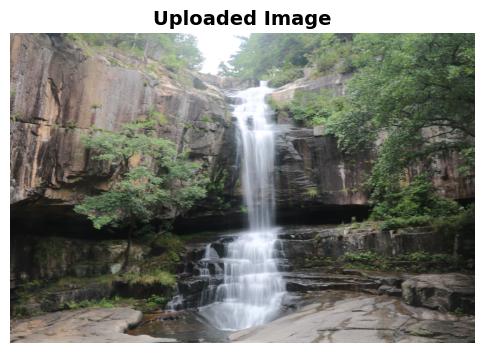


🎯 선택된 해시태그
Object : #valley
Scene  : #outdoor #mountain
Mood   : #vivid #clean


In [12]:
run_infer_and_show("./test/KakaoTalk_20251028_085926283_23.jpg")